In [215]:
import numpy as np
import math
import torch
import sys
from matplotlib import pyplot as plt
from matplotlib import colors as clrs

In [57]:
if sys.platform == "darwin":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Q 3.1

### Logistic Regression

In [300]:
# Create dataloaders
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, i):
        return self.data[i], self.labels[i]

class LinearLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 2)
        return self.layers(x)

class KernelLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

class LinearSVM(torch.nn.Module):
    def __init__(self):
        super(LinearSVM, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 1, bias=True)
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 2)
        return self.layers(x)

class KernelSVM(torch.nn.Module):
    def __init__(self):
        super(KernelSVM, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

def run_knn(k, X_train, Y_train, X_test):
    distances = -2*(X_test@X_train.T) + \
                torch.sum(torch.square(X_train), axis=1) + \
                torch.sum(torch.square(X_test), axis=1).unsqueeze_(-1)
    sorted_indices = torch.argsort(distances, axis = 1)[:, :k]
    knn = Y_train[sorted_indices].astype(np.int32)
    return knn

## Q 3.2

In [286]:
# Create Dataset
mu = torch.tensor([2.5, 0])
a  = []
b = []
positive_example_sampler = torch.distributions.MultivariateNormal(mu, torch.eye(2))
negative_example_sampler = torch.distributions.MultivariateNormal(-mu, torch.eye(2))
for _ in range(750):
    a.append(positive_example_sampler.sample().view(1,2))
    b.append(negative_example_sampler.sample().view(1,2))

postive_data_points = torch.stack(a).view(750, 2)
negative_data_points = torch.stack(b).view(750, 2)

In [287]:
data_set = torch.cat((postive_data_points, negative_data_points))
labels = torch.cat((torch.ones(750, 1), torch.zeros(750, 1)))
shuffle_index = torch.randperm(data_set.shape[0])
data_set = data_set[shuffle_index]
labels = labels[shuffle_index]

In [288]:
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]] 

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

In [298]:
def get_prediction(model, data):
    return model(data).detach()

def get_accuracy(predictions, labels):
    threshold = torch.tensor([0.5])
    predictions = (predictions >= threshold).float()*1
    return float(torch.count_nonzero((labels == predictions)))/float(len(labels))

def report_acc_decision_boundary(model, test_set_loader):
    for data, labels in test_set_loader:
        predictions = get_prediction(model, data)
        accuracy = get_accuracy(predictions, labels)
        print(f" Accuracy of model on test set: {accuracy*100}%")
    return

def draw_decision_boundary(model, test_dataset):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()

    x_min, x_max = test_set.data.min() - 1, test_set.data.max() + 1
    y_min, y_max = test_set.data.min() - 1, test_set.data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01).astype(np.float32),
                        np.arange(y_min, y_max, 0.01).astype(np.float32))
    preds = get_prediction(model, torch.hstack((torch.from_numpy(xx.ravel()).view(len(xx.ravel()), 1), torch.from_numpy(yy.ravel()).view(len(xx.ravel()), 1))))
    threshold = torch.tensor([0.5])
    preds = (preds >= threshold).float()*1
    preds = preds.reshape(xx.shape)
    plt.contourf(xx, yy, preds, cmap='Paired_r', alpha=0.5)
    plt.contour(xx, yy, preds, colors='k', linewidths=0.7)

    ax.scatter(test_dataset.data[:, 0], test_dataset.data[:, 1], c=test_dataset.labels ,cmap = clrs.ListedColormap(["blue", "red"]))
    plt.title("Decision Boundary for Linear Regression")

    plt.show()
    return

def train_logistic_regression(model, train_loader, validation_loader, learning_rate, losses):
    criterion = torch.nn.BCELoss(reduction='mean')
    threshold = 1e-5
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf

    while loss_reduction >= threshold:
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Evaluate on validation set
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data)
            curr_loss = criterion(val_predictions, val_labels).item()
        loss_reduction = abs(curr_loss/prev_loss - 1.0)
        prev_loss = curr_loss
        losses.append(prev_loss)
    return

def train_linear_svm(model, train_loader, validation_loader, learning_rate, losses):
    criterion = torch.nn.BCELoss(reduction='mean')
    threshold = 1e-5
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf

    while loss_reduction >= threshold:
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Evaluate on validation set
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data)
            curr_loss = criterion(val_predictions, val_labels).item()
        loss_reduction = abs(curr_loss/prev_loss - 1.0)
        prev_loss = curr_loss
        losses.append(prev_loss)
    return


#### Logistic Regression - Report Accuracy and draw Decision Boundary

In [ ]:
# Train model
linear_lr_model = LinearLogisticRegression()
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

In [291]:
#Report Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

#Draw - decision boundary
draw_decision_boundary(linear_lr_model, test_set)

 Accuracy of model on test set: 100.0%


#### Linear SVM

In [301]:
linear_svm_model = LinearSVM()
losses = []


### Q 3.2

In [293]:
import sklearn

In [296]:
data_set_tuples = sklearn.datasets.make_circles(1500)

data_set = torch.zeros((len(data_set_tuples[0]), 2), dtype=torch.float)
labels = torch.zeros((len(data_set_tuples[0]), 1), dtype=torch.float)
data_set.copy_(torch.from_numpy(data_set_tuples[0].astype(np.float32)))
labels.copy_(torch.from_numpy(data_set_tuples[1].astype(np.float32)).view((len(data_set_tuples[0]), 1)))
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]]

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

#### Linear Regression Model

 Accuracy of model on test set: 52.800000000000004%


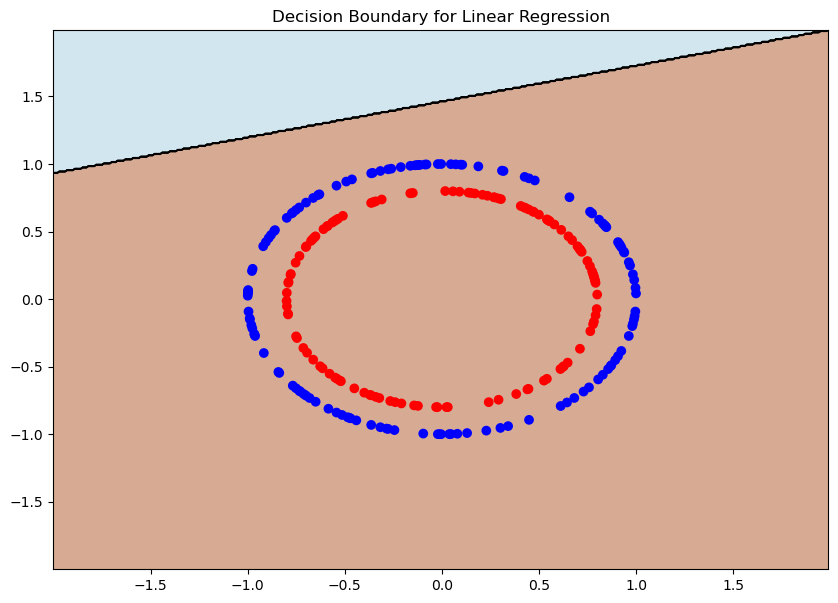

In [297]:
linear_lr_model = LinearLogisticRegression()
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

#Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

#Decision Boundary
draw_decision_boundary(linear_lr_model, test_set)

#### Linear SVM Model